In [1]:
import numpy as np
import pandas as pd
import math

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib import pyplot
from PIL import Image

from sklearn.model_selection import train_test_split

keras.backend.set_image_data_format('channels_last')

# How to train a model:
# https://www.kaggle.com/manthankyada/mnist-digit-classification-cnn-beginner-s-guide
# Image tutorial, matplotlib:
# https://matplotlib.org/tutorials/introductory/images.html

In [2]:
mnist_train = pd.read_csv('train.csv')#----- Train data to be split into X_train, X_test, y_train, y_test
test_dataset = pd.read_csv('test.csv')#----- the new data, which has to be succesfully classified by the _model_

In [3]:
# Spliting the data to X, y           # do take notice that column ['label'] is part of the imported dataset
X = mnist_train.drop('label', axis=1) # and since that column contains the values we want to predict, it is
y = mnist_train['label']              # dropped from X and assigned to y


# -------------------------------- After watching a standford class a trial is made without normalizing data.
# https://www.youtube.com/watch?v=wEoyxE0GP2M&list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv&index=6
# -------------------------------- and the results are bad. Fig 4 is a 0 that is guessed as a 9 by the three CNN's
# -------------------------------- so a test with only the training_set being normalized is performed
# -------------------------------- and results remain the same. Fig 4 is still being confused for a 9 :(
# Normalize values remains a good practice
X = X / 255.0
test_dataset = test_dataset / 255.0

In [4]:
# Reshape to 28 x 28 so that we can see the image ie. handwritten number
X = X.values.reshape(-1, 28, 28, 1)
test_dataset = test_dataset.values.reshape(-1, 28, 28, 1)

# Split between train and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Get one hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

#### Thingy to print images, uses max(2, math.ceil()) to prevent errors

In [15]:
def queso(model, X, imgs):
    s = max(2,math.ceil(np.sqrt(imgs)))
    fig, ax = plt.subplots(s, s, sharex=True, sharey=True, figsize=(s*1.5, s*1.5))
    fig.tight_layout(pad=3.0)
    ax = ax.flatten()
    preds = model.predict(X[:imgs])
    for i in range(imgs):
        y_pred = np.argmax(preds[i])
        img = X[i].reshape(28, 28)
        ax[i].imshow(img, cmap='Greys', interpolation='nearest')
        ax[i].set_title(f'p: {y_pred}')

## Model from kaggle

In [6]:
# Build a Convolutional Neural Network Model
def CNN():
    model = keras.Sequential()
    # CONV > CONV > BN > RELU > MAXPOOLING > DROPOUT
    model.add(layers.Conv2D(32, (3, 3), (1, 1), padding='valid', input_shape=(28, 28, 1), name='conv2d_1_1'))
    model.add(layers.Conv2D(32, (3, 3), (1, 1), padding='same', name='conv2d_1_2'))
    model.add(layers.BatchNormalization(name='bn_1'))
    model.add(layers.Activation('relu', name='relu_1'))
    model.add(layers.MaxPooling2D((2, 2), (2, 2), padding='valid', name='mp2d_1'))
    model.add(layers.Dropout(0.2, name='drop_1'))
    # CONV > CONV > BN > RELU > MAXPOOLING > DROPOUT
    model.add(layers.Conv2D(64, (3, 3), (1, 1), padding='valid', name='conv2d_2_1'))
    model.add(layers.Conv2D(64, (3, 3), (1, 1), padding='same', name='conv2d_2_2'))
    model.add(layers.BatchNormalization(name='bn_2'))
    model.add(layers.Activation('relu', name='relu_2'))
    model.add(layers.MaxPooling2D((2, 2), (2, 2), padding='valid', name='mp2d_2'))
    model.add(layers.Dropout(0.2, name='drop_2'))
    # FLATTEN > DENSE > CLASSIFICATION
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    return model
model = CNN()

# Source:
# https://www.kaggle.com/manthankyada/mnist-digit-classification-cnn-beginner-s-guide

In [7]:
model.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy'])

In [8]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=15, verbose=1)

Epoch 1/15
525/525 [==============================] - 52s 98ms/step - loss: 0.1983 - accuracy: 0.9373 - val_loss: 0.1237 - val_accuracy: 0.9612
Epoch 2/15
525/525 [==============================] - 52s 98ms/step - loss: 0.0739 - accuracy: 0.9768 - val_loss: 0.0544 - val_accuracy: 0.9836
Epoch 3/15
525/525 [==============================] - 53s 100ms/step - loss: 0.0497 - accuracy: 0.9834 - val_loss: 0.0691 - val_accuracy: 0.9804
Epoch 4/15
525/525 [==============================] - 52s 99ms/step - loss: 0.0438 - accuracy: 0.9854 - val_loss: 0.0469 - val_accuracy: 0.9857
Epoch 5/15
525/525 [==============================] - 53s 101ms/step - loss: 0.0368 - accuracy: 0.9879 - val_loss: 0.0498 - val_accuracy: 0.9839
Epoch 6/15
525/525 [==============================] - 52s 99ms/step - loss: 0.0337 - accuracy: 0.9895 - val_loss: 0.0460 - val_accuracy: 0.9870
Epoch 7/15
525/525 [==============================] - 53s 100ms/step - loss: 0.0279 - accuracy: 0.9911 - val_loss: 0.0489 - val_accura

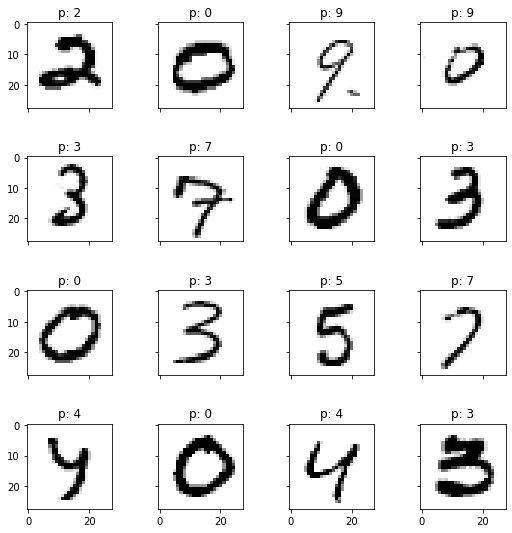

In [9]:
queso(model, test_dataset, 16)

## Model based on stanford class

In [10]:
stan_model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(128, (3, 3)),
    tf.keras.layers.Conv2D(128, (3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 100 neuron hidden layer
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# source:
# https://www.youtube.com/watch?v=bNb2fEVKeEo&list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv&index=5

In [11]:
stan_model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
stan_history = stan_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=15, verbose=1)

In [ ]:
queso(stan_model,test_dataset,16)

## Model from Google I/O in modified form

In [20]:
lm_model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(128, (3, 3),  activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.05),
    # The second convolution
    tf.keras.layers.Conv2D(256, (3, 3),  activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3),  activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 128 neuron hidden layer
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# source:
# https://github.com/lmoroney/io19/blob/master/Zero%20to%20Hero/Rock-Paper-Scissors.ipynb
# inspired from video:
# https://www.youtube.com/watch?v=VwVg9jCtqaU

In [21]:
lm_model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
lm_history = lm_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=15, verbose=1)

Epoch 1/15
1050/1050 [==============================] - 141s 135ms/step - loss: 0.1189 - accuracy: 0.9643 - val_loss: 0.0708 - val_accuracy: 0.9793
Epoch 2/15
1050/1050 [==============================] - 147s 140ms/step - loss: 0.0561 - accuracy: 0.9838 - val_loss: 0.0530 - val_accuracy: 0.9860
Epoch 3/15
1050/1050 [==============================] - 149s 141ms/step - loss: 0.0411 - accuracy: 0.9879 - val_loss: 0.0979 - val_accuracy: 0.9739
Epoch 4/15
1050/1050 [==============================] - 150s 143ms/step - loss: 0.0351 - accuracy: 0.9899 - val_loss: 0.0594 - val_accuracy: 0.9843
Epoch 5/15
1050/1050 [==============================] - 147s 140ms/step - loss: 0.0273 - accuracy: 0.9917 - val_loss: 0.0877 - val_accuracy: 0.9806
Epoch 6/15
1050/1050 [==============================] - 146s 139ms/step - loss: 0.0258 - accuracy: 0.9927 - val_loss: 0.3331 - val_accuracy: 0.9139
Epoch 7/15
1050/1050 [==============================] - 153s 145ms/step - loss: 0.0169 - accuracy: 0.9949 - val_

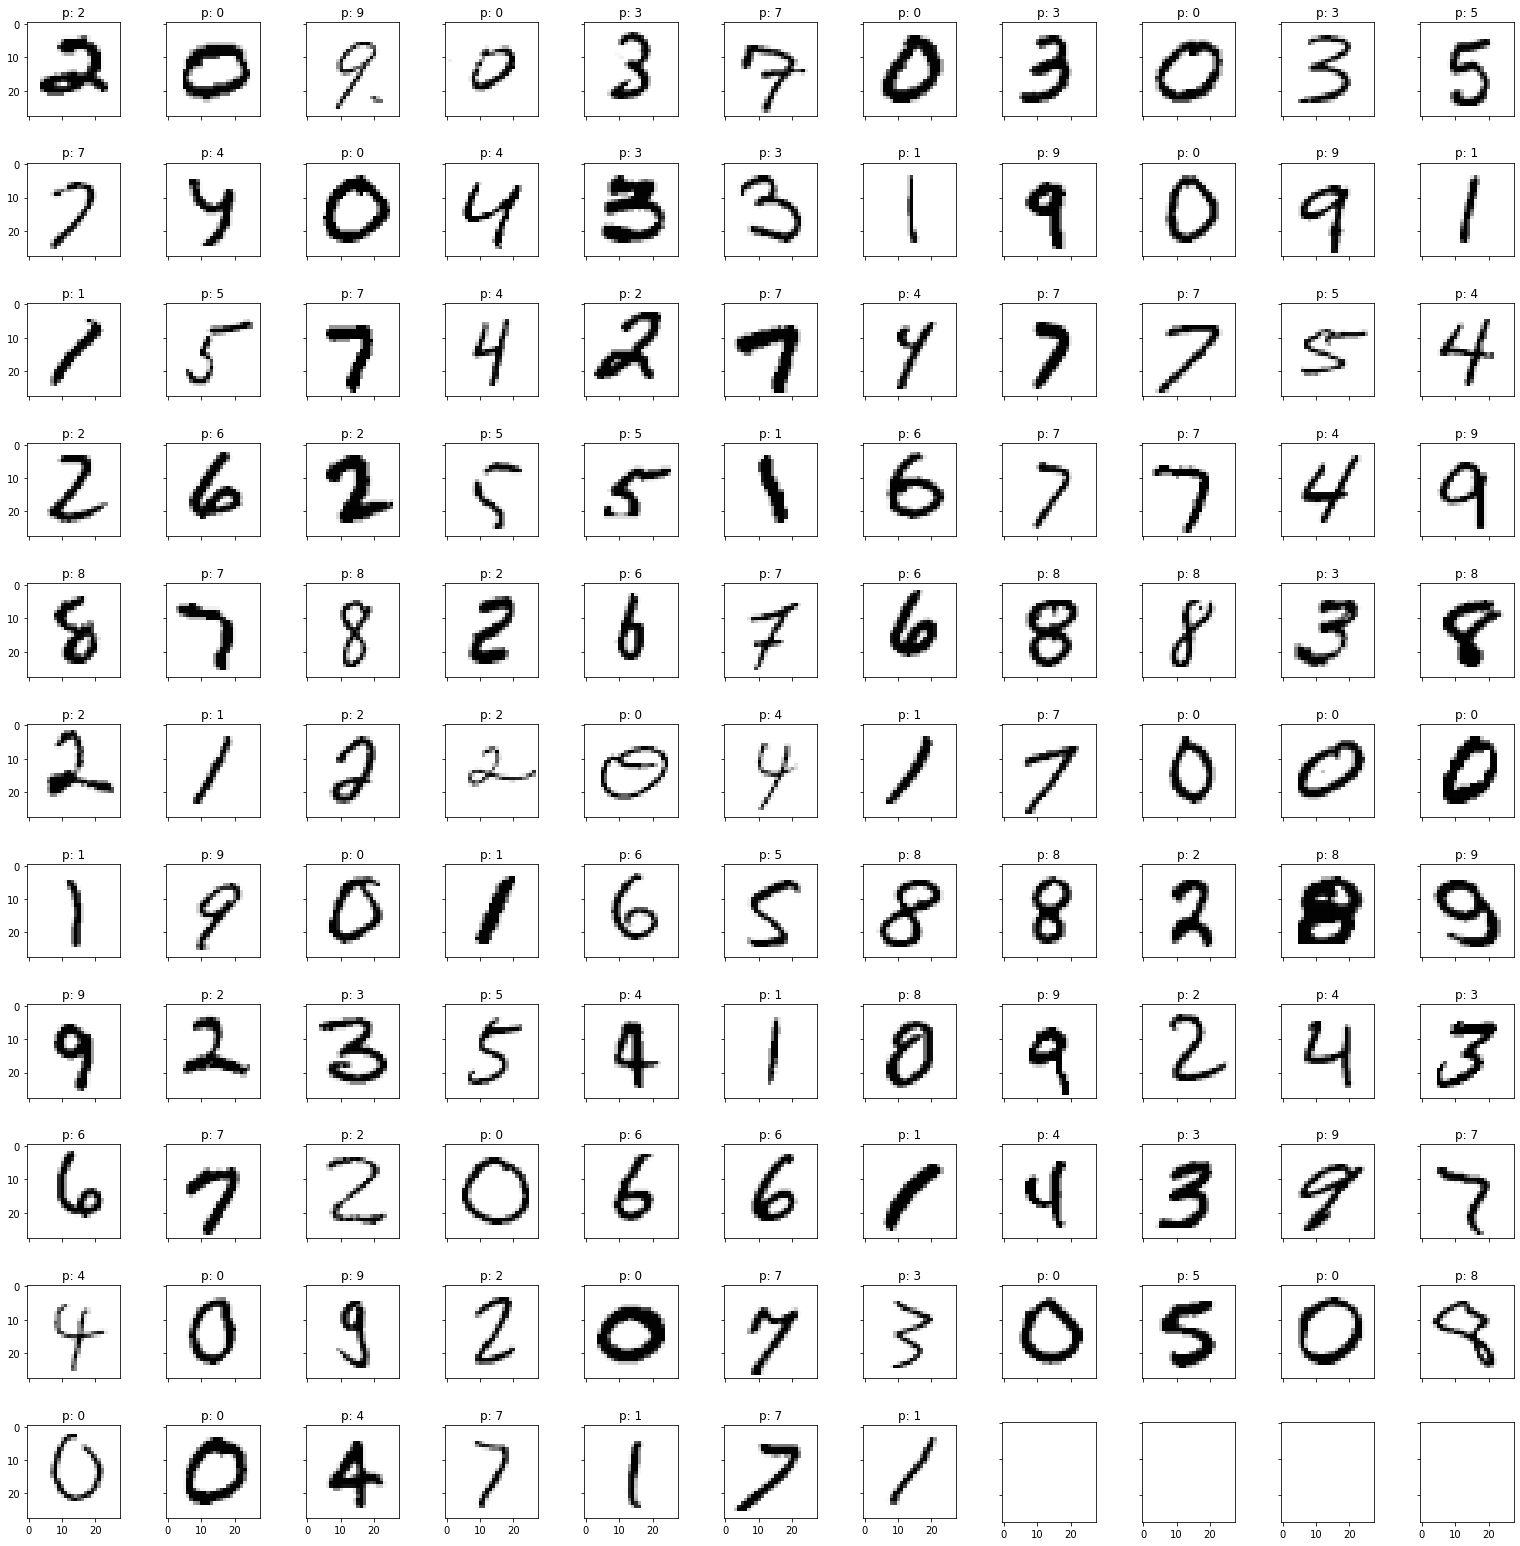

In [26]:
queso(lm_model,test_dataset,117)

## Model based on code from Keras blog

##### Source:
##### https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [19]:
ke_model = tf.keras.models.Sequential([
    # The first convolution
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(28, 28, 1)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(256, (3, 3),activation='relu'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The third convolution
    tf.keras.layers.Conv2D(256, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    # this converts our 3D feature maps to 1D feature vectors
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Activation('softmax')

    ])

In [14]:
ke_model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
ke_history = ke_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=15, verbose=1)

Epoch 1/15
1050/1050 [==============================] - 14s 14ms/step - loss: 0.0413 - accuracy: 0.9226 - val_loss: 0.0206 - val_accuracy: 0.9639
Epoch 2/15
1050/1050 [==============================] - 16s 15ms/step - loss: 0.0146 - accuracy: 0.9755 - val_loss: 0.0137 - val_accuracy: 0.9770
Epoch 3/15
1050/1050 [==============================] - 16s 15ms/step - loss: 0.0102 - accuracy: 0.9829 - val_loss: 0.0149 - val_accuracy: 0.9763
Epoch 4/15
1050/1050 [==============================] - 16s 15ms/step - loss: 0.0079 - accuracy: 0.9872 - val_loss: 0.0108 - val_accuracy: 0.9821
Epoch 5/15
1050/1050 [==============================] - 16s 15ms/step - loss: 0.0064 - accuracy: 0.9895 - val_loss: 0.0110 - val_accuracy: 0.9814
Epoch 6/15
1050/1050 [==============================] - 16s 15ms/step - loss: 0.0048 - accuracy: 0.9919 - val_loss: 0.0113 - val_accuracy: 0.9826
Epoch 7/15
1050/1050 [==============================] - 16s 15ms/step - loss: 0.0043 - accuracy: 0.9932 - val_loss: 0.0109 -

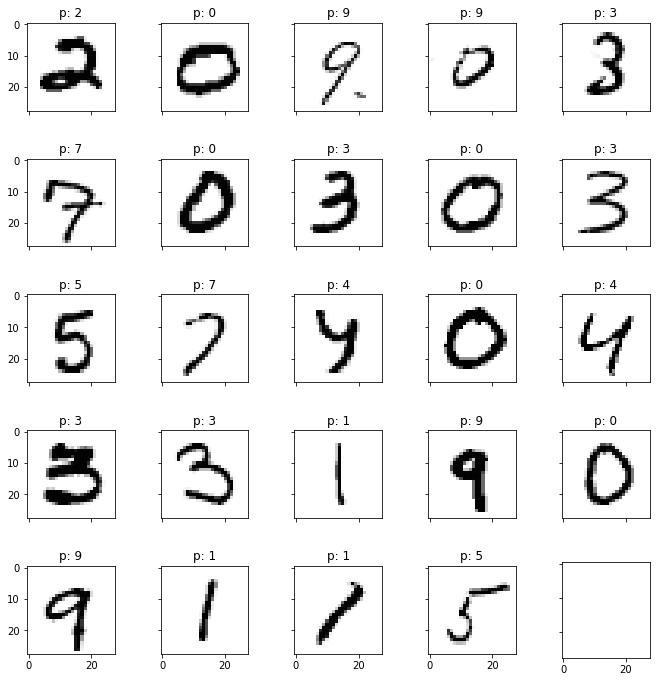

In [16]:
queso(ke_model,test_dataset,24)

## 3b1b inspired model

In [17]:
mod_3b1b = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(128, (3, 3), input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3, 3),  activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3),  activation='relu'),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 128 neuron hidden layer
    tf.keras.layers.Dense(10, activation='softmax')
])


# inspired from video:
# https://www.youtube.com/watch?v=Ilg3gGewQ5U

In [18]:
mod_3b1b.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
history_3b1b = mod_3b1b.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=15, verbose=1)

Epoch 1/15
1050/1050 [==============================] - 88s 83ms/step - loss: 0.0293 - accuracy: 0.9473 - val_loss: 0.0179 - val_accuracy: 0.9698
Epoch 2/15
1050/1050 [==============================] - 91s 87ms/step - loss: 0.0116 - accuracy: 0.9809 - val_loss: 0.0133 - val_accuracy: 0.9795
Epoch 3/15
1050/1050 [==============================] - 92s 87ms/step - loss: 0.0086 - accuracy: 0.9860 - val_loss: 0.0160 - val_accuracy: 0.9740
Epoch 4/15
1050/1050 [==============================] - 92s 88ms/step - loss: 0.0083 - accuracy: 0.9861 - val_loss: 0.0113 - val_accuracy: 0.9808
Epoch 5/15
1050/1050 [==============================] - 92s 87ms/step - loss: 0.0067 - accuracy: 0.9889 - val_loss: 0.0138 - val_accuracy: 0.9794
Epoch 6/15
1050/1050 [==============================] - 92s 87ms/step - loss: 0.0055 - accuracy: 0.9908 - val_loss: 0.0130 - val_accuracy: 0.9823
Epoch 7/15
1050/1050 [==============================] - 92s 88ms/step - loss: 0.0061 - accuracy: 0.9900 - val_loss: 0.0125 -

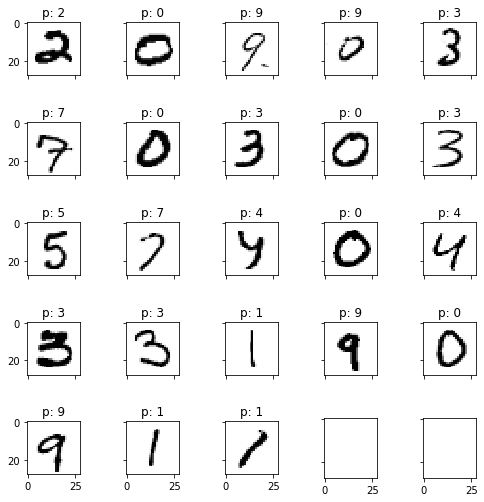

In [21]:
queso(mod_3b1b,test_dataset,23)

## Saving model

In [27]:
# Since the code from google is the one I personally like the best, that is the one trained model I'll be saving

lm_model.save("15-epochs_0-9_classifier_NN.h5")

lm_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 24, 24, 128)       36992     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 12, 12, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 10, 10, 256)       295168    
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 256)         590080    
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 256)        

## Import, grayscale, reshape

In [ ]:
#--------------------------------- LOAD IMAGE
original = Image.open('8.png')
gray = original.convert('LA')
cp_original = original.copy()
cp_gray = gray.copy()
#--------------------------------- NORMAL SIZE
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(10, 10))

ax1 = plt.subplot(331)
ax2 = plt.subplot(333)
ax1.imshow(original)
ax1.set_title("original")
ax2.imshow(gray)
ax2.set_title("grayscale")
#--------------------------------- RESIZED
cp_original.thumbnail((28, 28), Image.ANTIALIAS)
cp_gray.thumbnail((28, 28), Image.ANTIALIAS)
ax3 = plt.subplot(334)
ax4 = plt.subplot(336)
ax3.imshow(cp_original)
ax3.set_title("original resized")
ax4.imshow(cp_gray)
ax4.set_title("gray resized")

plt.show()


In [ ]:
original.thumbnail((28, 28), Image.ANTIALIAS)
d4_img = np.array(original)
d4_img.shape

# Next steps:

#### 1. Load ONE vehicle plate number 
#### 2. Identify individual numbers
#### 3. Train lm_model, which was saved as "0-9_classifier_NN.h5", to also identify UPPERCASE LETTERS ONLY